In [1]:
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
  -O cats_and_dogs_filtered.zip

--2021-07-09 22:31:52--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.128, 142.250.141.128, 74.125.137.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   123MB/s    in 0.5s    

2021-07-09 22:31:53 (123 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [3]:
! unzip -q cats_and_dogs_filtered.zip

replace cats_and_dogs_filtered/vectorize.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [4]:
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Input
import numpy as np

In [5]:
train_dir = "cats_and_dogs_filtered/train/"
validation_dir = "cats_and_dogs_filtered/validation/"
trdata = ImageDataGenerator()
traindata = trdata.flow_from_directory(directory=train_dir, batch_size=20, target_size=(224,224))
tsdata = ImageDataGenerator()
testdata = tsdata.flow_from_directory(directory=validation_dir, batch_size=20, target_size=(224,224))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Reescribir la red utilizando el método funcional y definiendo una función de ayuda.

In [6]:
## inputs = Input(shape=(224,224,3)), etc.
def create_block(n_filters, n_layers, inputs):
    '''
    Entradas:
     n_filters: numero de filtros del bloque
     n_layers: número de capas del bloque
     inputs: tensor de entrada
    Retorna:
     tensor de salida con las capas aplicadas
    '''
    # usar un bucle for para agregar n_layers capas convolucionales
    # luego, agregar la capa MaxPool2D y retornarla
    for i in range(n_layers):
      inputs = Conv2D(filters=n_filters,kernel_size=(3,3),padding="same", activation="relu")(inputs)
    inputs=MaxPool2D(pool_size=(2,2),strides=(2,2))(inputs)
    return inputs # retornar el tensor
    

#model = Sequential()
#model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
#model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
#model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
#model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
#model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
#model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
#model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
#model.add(Flatten())
#model.add(Dense(units=4096,activation="relu"))
#model.add(Dense(units=4096,activation="relu"))
#model.add(Dense(units=2, activation="softmax"))

# reemplazar los bloques usando la función create_block
inputs = Input(shape=(224,224,3))
x = create_block(64,2,inputs)
x = create_block(128,2,x)
x = create_block(256,3,x)
x = create_block(512,3,x)
x = create_block(512,3,x)
x = Flatten()(x)
x = Dense(units=4096,activation="relu")(x)
x = Dense(units=4096,activation="relu")(x)
x = Dense(units=2, activation="softmax")(x)
model = Model(inputs, x)


from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss=categorical_crossentropy, metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0     

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_accuracy', verbose=2, save_best_only=True, 
                             save_weights_only=False, mode='auto')
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')


In [8]:
hist = model.fit_generator(steps_per_epoch=100,generator=traindata, validation_data= testdata, validation_steps=10,epochs=10,callbacks=[checkpoint,early])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
100/100 [==============================] - 46s 314ms/step - loss: 282.1396 - accuracy: 0.4725 - val_loss: 0.6926 - val_accuracy: 0.5450

Epoch 00001: val_accuracy improved from -inf to 0.54500, saving model to vgg16_1.h5
Epoch 2/10
100/100 [==============================] - 35s 346ms/step - loss: 0.7042 - accuracy: 0.4935 - val_loss: 0.6936 - val_accuracy: 0.4850

Epoch 00002: val_accuracy did not improve from 0.54500
Epoch 3/10
100/100 [==============================] - 31s 305ms/step - loss: 0.6934 - accuracy: 0.4780 - val_loss: 0.6933 - val_accuracy: 0.4750

Epoch 00003: val_accuracy did not improve from 0.54500
Epoch 4/10
100/100 [==============================] - 31s 306ms/step - loss: 0.6934 - accuracy: 0.4910 - val_loss: 0.6932 - val_accuracy: 0.5000

Epoch 00004: val_accuracy did not improve from 0.54500
Epoch 5/10
100/100 [==============================] - 31s 307ms/step - loss: 0.6933 - accuracy: 0.4920 - val_loss: 0.6930 - val_accuracy: 0.5600

Epoch 00005: val_ac

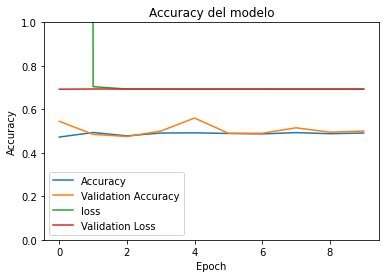

In [10]:
import matplotlib.pyplot as plt
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylim((0,1))
plt.title("Accuracy del modelo")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [18]:
arena_generator = tsdata.flow_from_directory(
        './Arena',
        target_size=(224, 224))

Found 3 images belonging to 2 classes.


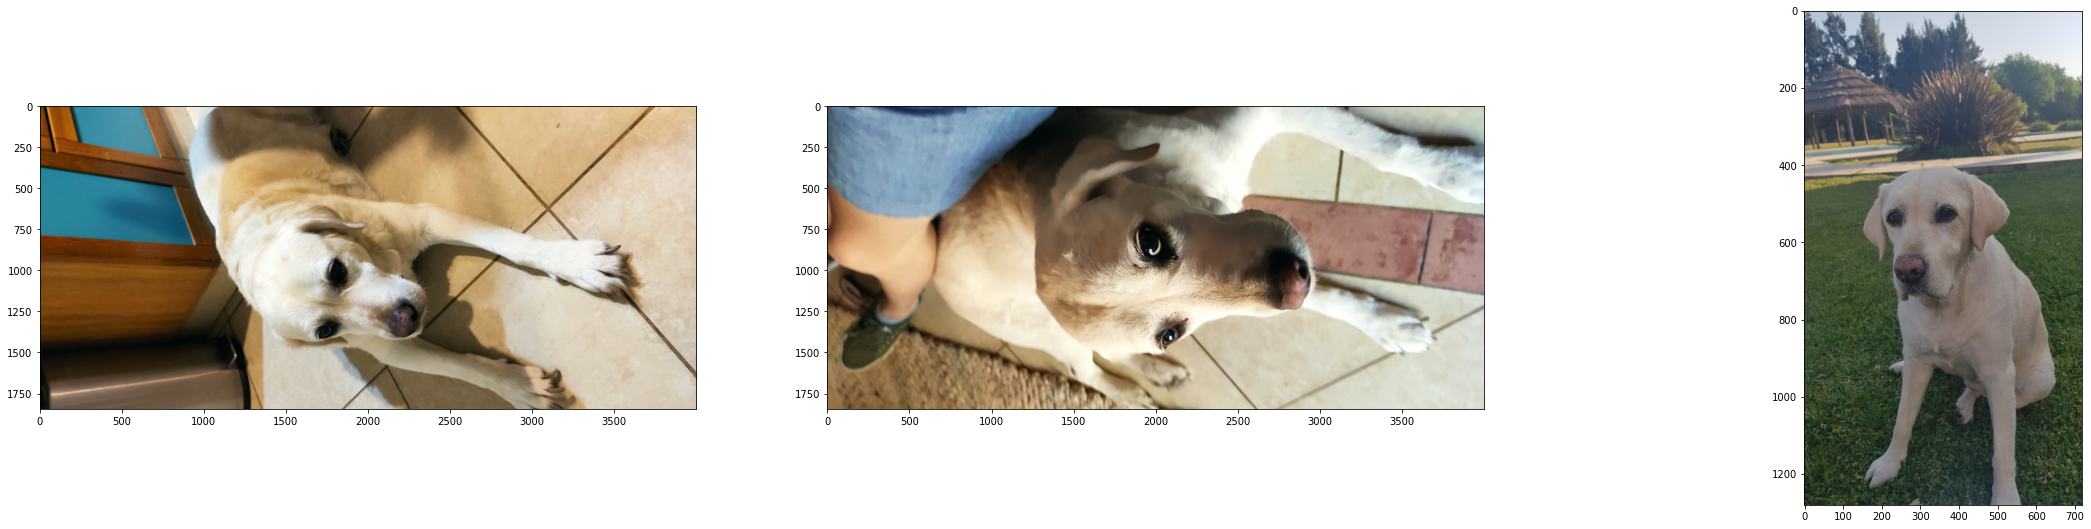

In [19]:
import matplotlib.image as mpimg
import glob
import os

files =glob.glob("./Arena/img/*.jpg")
plt.figure(figsize=(40,20))
i=1
for f in files:
  plt.subplot(2,3,i)
  image = mpimg.imread(f)
  plt.imshow(image)
  i+=1
    
plt.show()

In [31]:
import tensorflow as tf
saved_model = tf.keras.models.load_model("vgg16_1.h5", compile=False)
predictions=saved_model.predict(arena_generator)
for output in predictions:
  if output[0] > output[1]:
      print("cat")
  else:
      print('dog')

dog
dog
dog


In [32]:
popy_generator = tsdata.flow_from_directory(
        './Popy',
        target_size=(224, 224),
        batch_size=4,
        shuffle=False)

Found 4 images belonging to 2 classes.


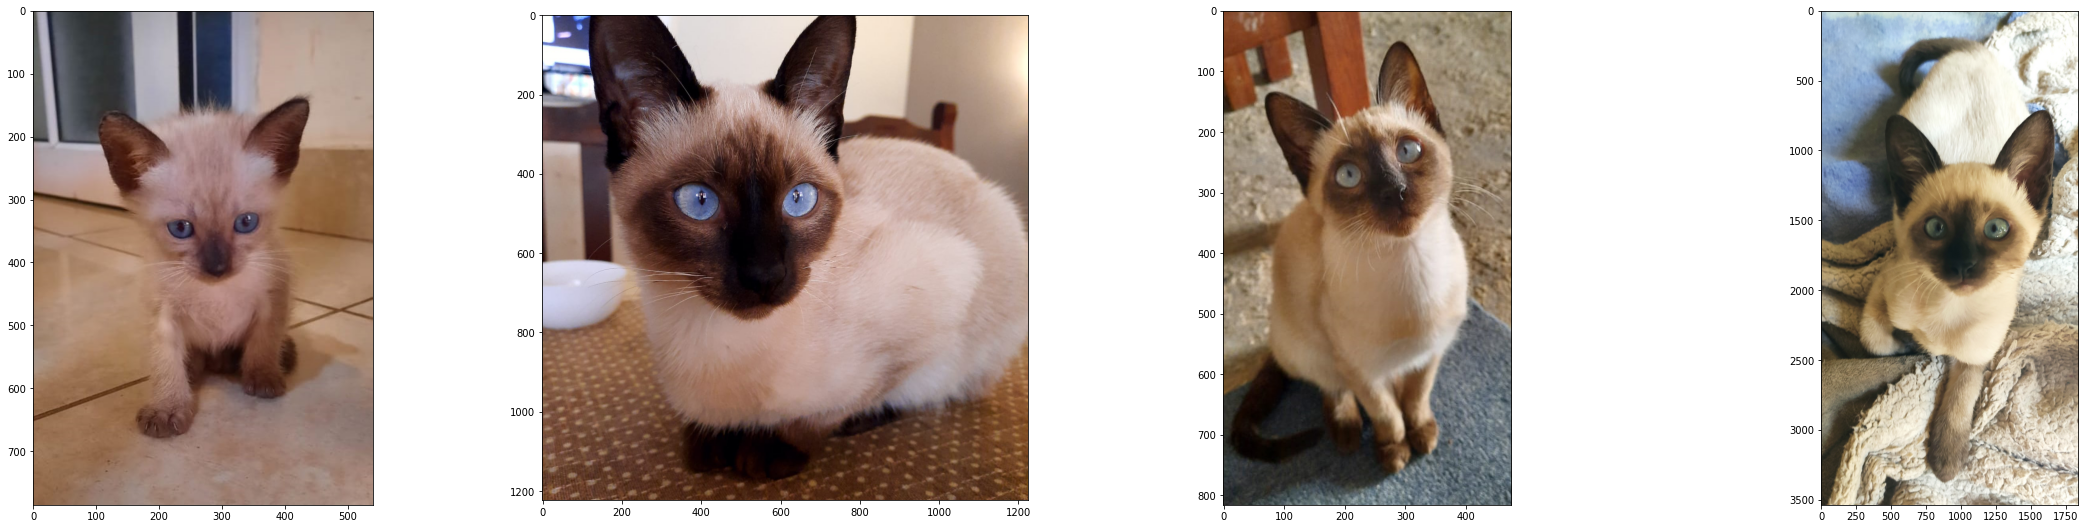

In [33]:
files =glob.glob("./Popy/img/*.jpg")
plt.figure(figsize=(40,20))
i=1
for f in files:
  plt.subplot(2,4,i)
  image = mpimg.imread(f)
  plt.imshow(image)
  i+=1
    
plt.show()

In [34]:
predictions = saved_model.predict(popy_generator)
for output in predictions:
  if output[0] > output[1]:
      print("cat")
  else:
      print('dog')

dog
dog
dog
dog
